<a href="https://colab.research.google.com/github/ttlttk8161/-PBL-Reinforcement-learning/blob/main/3_TD_share.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from grid_world import GridWorld

env = GridWorld(size=4)

ModuleNotFoundError: No module named 'grid_world'

In [ ]:
!pip install koreanize_matplotlib -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 67.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import koreanize_matplotlib

def plot_learning_curve(episode_rewards, title="TD 학습", window=100):
    """학습 곡선 시각화"""
    plt.figure(figsize=(12, 6))

    # 에피소드별 보상
    plt.subplot(1, 2, 1)
    plt.plot(episode_rewards, alpha=0.3, color='lightblue', label='에피소드 보상')

    # 이동 평균 계산
    moving_avg = []
    for i in range(len(episode_rewards)):
        start_idx = max(0, i - window + 1)
        moving_avg.append(np.mean(episode_rewards[start_idx:i+1]))

    plt.plot(moving_avg, color='red', linewidth=2, label=f'{window}에피소드 이동평균')
    plt.xlabel('에피소드')
    plt.ylabel('누적 보상')
    plt.title(f'{title} 학습 곡선')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 최근 성능 히스토그램
    plt.subplot(1, 2, 2)
    recent_rewards = episode_rewards[-200:]  # 최근 200 에피소드
    plt.hist(recent_rewards, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    plt.xlabel('누적 보상')
    plt.ylabel('빈도')
    plt.title('최근 200에피소드 보상 분포')
    plt.axvline(np.mean(recent_rewards), color='red', linestyle='--',
               label=f'평균: {np.mean(recent_rewards):.2f}')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_value_function(Q):
    """학습된 가치함수 시각화"""
    if not Q:
        print("학습된 Q-테이블이 없습니다.")
        return

    states = list(Q.keys())

    # 상태값 계산 (각 상태에서의 최대 Q값)
    state_values = {}
    for state in states:
        if Q[state]:
            state_values[state] = max(Q[state].values())
        else:
            state_values[state] = 0.0

    # 그리드 형태로 시각화 시도
    try:
        if isinstance(states[0], tuple) and len(states[0]) == 2:
            # 2D 그리드 환경 (예: GridWorld)
            max_row = max(s[0] for s in states) + 1
            max_col = max(s[1] for s in states) + 1

            value_grid = np.zeros((max_row, max_col))
            for state, value in state_values.items():
                value_grid[state[0], state[1]] = value

            plt.figure(figsize=(10, 8))
            im = plt.imshow(value_grid, cmap='viridis', interpolation='nearest')
            plt.colorbar(im, label='상태 가치')
            plt.title('학습된 가치함수 히트맵')
            plt.xlabel('열 위치')
            plt.ylabel('행 위치')

            # 각 셀에 값 표시
            for i in range(max_row):
                for j in range(max_col):
                    plt.text(j, i, f'{value_grid[i, j]:.2f}',
                           ha='center', va='center', color='white', fontweight='bold')

            plt.show()
        else:
            # 1D 상태 공간 또는 정수 상태
            sorted_states = sorted(states)
            values = [state_values[s] for s in sorted_states]

            plt.figure(figsize=(12, 6))
            plt.bar(range(len(sorted_states)), values, alpha=0.7, color='skyblue')
            plt.xlabel('상태')
            plt.ylabel('가치')
            plt.title('상태별 가치함수')
            plt.xticks(range(len(sorted_states)), [str(s) for s in sorted_states], rotation=45)
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()

    except Exception as e:
        print(f"가치함수 시각화 중 오류 발생: {e}")
        # 대안 시각화
        sorted_items = sorted(state_values.items())
        values = [v for s, v in sorted_items]

        plt.figure(figsize=(12, 6))
        plt.plot(values, marker='o', linestyle='-', color='blue', markersize=6)
        plt.xlabel('상태 인덱스')
        plt.ylabel('가치')
        plt.title('상태별 가치함수')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

def plot_results(Q, episodes, rewards, steps, title="TD 학습"):
    """결과 시각화"""
    plot_learning_curve(rewards, title)
    plot_value_function(Q)

---

# TD 0

TD(0) 학습 시작...
에피소드 100: 평균 보상 = 9.37
에피소드 200: 평균 보상 = 9.41
에피소드 300: 평균 보상 = 9.45
에피소드 400: 평균 보상 = 9.49
에피소드 500: 평균 보상 = 9.39
에피소드 600: 평균 보상 = 9.47
에피소드 700: 평균 보상 = 9.38
에피소드 800: 평균 보상 = 9.44
에피소드 900: 평균 보상 = 9.42
에피소드 1000: 평균 보상 = 9.46
TD(0) 학습 완료!


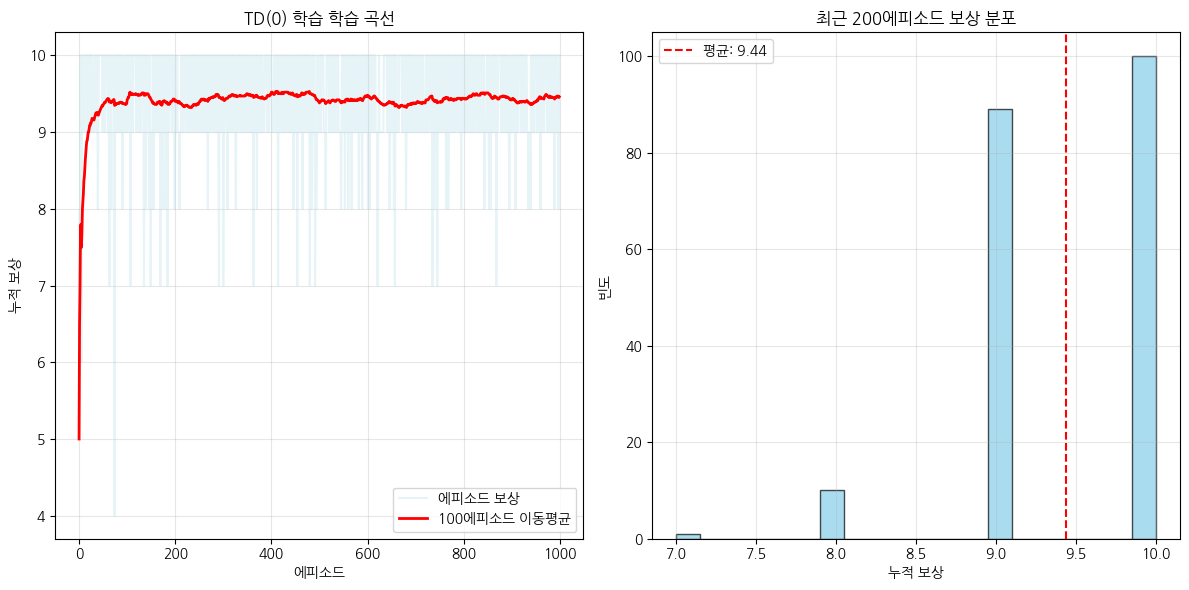

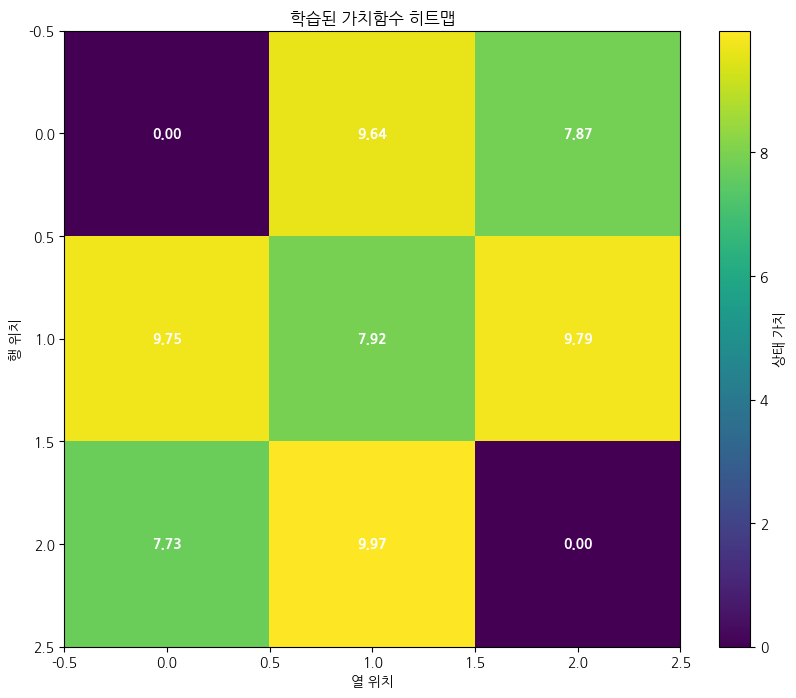

In [ ]:
# TD(0) 알고리즘 - 가장 기본적인 시간차 학습 방법

# 환경 설정
env = GridWorld(size=3)
alpha = 0.1  # 학습률(learning rate)
gamma = 0.9  # 할인율(discount factor)
epsilon = 0.1  # 탐험율(exploration rate)
episodes = 1000

# 1. 정책 π와 가치함수 V(s)를 초기화
V = defaultdict(float)  # 상태 가치함수 V(s)
Q = defaultdict(lambda: defaultdict(float))  # Q(s,a) 함수 (가치함수 시각화를 위해 추가)
policy = defaultdict(str)  # 정책 π(s)

# 정책과 가치함수 초기화
for state in env.states:
    if not env.is_terminal(state):
        # 임의의 행동으로 정책 초기화
        policy[state] = np.random.choice(env.actions)
    V[state] = 0.0  # 가치함수 초기화
    # Q 함수 초기화
    for action in env.actions:
        Q[state][action] = 0.0

# 학습 기록
episode_rewards = []
episode_steps = []

print("TD(0) 학습 시작...")

# 2. 반복:
for episode in range(episodes):
    total_reward = 0
    step_count = 0

    # 초기 상태 선택 (터미널 상태가 아닌 상태에서 시작)
    non_terminal_states = [s for s in env.states if not env.is_terminal(s)]
    state = non_terminal_states[np.random.randint(len(non_terminal_states))]

    while not env.is_terminal(state) and step_count < 1000:
        # a. 현재 상태 s 관찰 (이미 state 변수에 저장됨)

        # b. 정책 π에 따라 행동 a 선택 및 실행 (ε-탐욕 정책 사용)
        if np.random.random() < epsilon:
            action = np.random.choice(env.actions)  # 탐험
        else:
            action = policy[state]  # 현재 정책에 따른 행동

        # c. 보상 r과 다음 상태 s' 관찰
        next_state = env.get_next_state(state, action)
        reward = env.get_reward(state, action, next_state)

        # d. TD 오차 = r + γV(s') - V(s) 계산
        # [TODO] TD 오차를 계산하세요.
        td_error = reward + gamma * V[next_state] - V[state]

        # e. V(s) = V(s) + α[TD 오차]  # α는 학습률(learning rate)
        V[state] = V[state] + alpha * td_error

        # Q 함수도 함께 업데이트 (시각화를 위해)
        Q[state][action] = V[state]

        # 정책 업데이트 (탐욕적 정책으로)
        if not env.is_terminal(state):
            best_action = None
            best_value = float('-inf')

            for act in env.actions:
                next_st = env.get_next_state(state, act)
                rew = env.get_reward(state, act, next_st)
                value = rew + gamma * V[next_st]

                if value > best_value:
                    best_value = value
                    best_action = act

            policy[state] = best_action

        # f. s = s'로 갱신
        # [TODO] 다음 상태로 현재 상태를 업데이트하세요
        state = next_state

        total_reward += reward
        step_count += 1

    episode_rewards.append(total_reward)
    episode_steps.append(step_count)

    # 진행상황 출력
    if (episode + 1) % 100 == 0:
        avg_reward = np.mean(episode_rewards[-100:])
        print(f"에피소드 {episode + 1}: 평균 보상 = {avg_reward:.2f}")

print("TD(0) 학습 완료!")

# 결과 시각화
plot_learning_curve(episode_rewards, "TD(0) 학습")
plot_value_function(dict(Q))

---

### TD0 Class ver

In [ ]:
class TDBase:
    """시간차 학습(Temporal Difference Learning)의 기본 클래스"""

    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.env = env
        self.alpha = alpha  # 학습률(learning rate)
        self.gamma = gamma  # 할인율(discount factor)
        self.epsilon = epsilon  # 탐험율(exploration rate)
        self.Q = defaultdict(lambda: defaultdict(float))  # Q(s,a) 테이블

    def epsilon_greedy_policy(self, state):
        """ε-탐욕 정책으로 행동 선택"""
        if np.random.random() < self.epsilon:
            return np.random.choice(self.env.actions)  # 탐험
        else:
            # 탐욕적 행동 선택 (Q값 기반)
            q_values = [self.Q[state][action] for action in self.env.actions]
            best_action_idx = np.argmax(q_values)
            return self.env.actions[best_action_idx]

    def get_q_value(self, state, action):
        """Q(s,a) 값 반환"""
        return self.Q[state][action]

    def update_step(self, state, action, reward, next_state, done):
        """한 스텝 업데이트 (서브클래스에서 구현)"""
        raise NotImplementedError("서브클래스에서 구현해야 합니다")

    def train(self, episodes=1000):
        """학습 실행"""
        episode_rewards = []
        episode_steps = []

        for episode in range(episodes):
            total_reward = 0
            step_count = 0
            # states가 리스트인지 확인하고 적절히 선택
            state = self.env.states[np.random.randint(len(self.env.states))]

            # 에피소드별 초기화 (서브클래스에서 필요시 오버라이드)
            self.reset_episode()

            while True:
                # 터미널 상태 확인
                if self.env.is_terminal(state):
                    break

                # ε-탐욕 정책에 따라 행동 선택 및 실행
                action = self.epsilon_greedy_policy(state)
                next_state = self.env.get_next_state(state, action)
                reward = self.env.get_reward(state, action, next_state)
                done = self.env.is_terminal(next_state)

                total_reward += reward
                step_count += 1

                # TD 업데이트 실행
                self.update_step(state, action, reward, next_state, done)

                # 다음 상태로 이동
                state = next_state

                if done:
                    break

            episode_rewards.append(total_reward)
            episode_steps.append(step_count)

            # 진행 상황 출력
            if episode % 100 == 0:
                avg_reward = np.mean(episode_rewards[-100:])
                print(f"에피소드 {episode}: 평균 보상 = {avg_reward:.2f}")

        return list(range(episodes)), episode_rewards, episode_steps

    def reset_episode(self):
        """에피소드 시작 시 초기화 (기본적으로는 아무것도 하지 않음)"""
        pass

    def plot_results(self, episodes, rewards, steps, title="TD 학습"):
        """결과 시각화"""
        plot_learning_curve(rewards, title)
        plot_value_function(self.Q)

In [ ]:
class TD0(TDBase):
    """
    TD(0) 알고리즘 - 가장 기본적인 시간차 학습 방법
    1. 정책 π와 가치함수 V(s)를 초기화
    2. 반복:
       a. 현재 상태 s 관찰
       b. 정책 π에 따라 행동 a 선택 및 실행
       c. 보상 r과 다음 상태 s' 관찰
       d. TD 오차 = r + γV(s') - V(s) 계산
       e. V(s) = V(s) + α[TD 오차]  # α는 학습률(learning rate)
       f. s = s'로 갱신
    """

    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=0.1):
        # 1. 정책 π와 가치함수 V(s)를 초기화
        super().__init__(env, alpha, gamma, epsilon)

    def update_step(self, state, action, reward, next_state, done):
        """
        TD(0) 업데이트:
        Q(s,a) ← Q(s,a) + α[r + γ * max_a'Q(s',a') - Q(s,a)]
        """
        # a. 현재 상태 s 관찰 (이미 완료)
        # b. 정책 π에 따라 행동 a 선택 및 실행 (이미 완료)
        # c. 보상 r과 다음 상태 s' 관찰 (이미 완료)

        # 현재 Q값 (V(s)에 해당)
        current_q = self.Q[state][action]

        # d. TD 오차 = r + γV(s') - V(s) 계산
        if done:
            target_q = reward
        else:
            # 다음 상태에서의 최대 Q값 (V(s')에 해당)
            next_q_values = [self.Q[next_state][a] for a in self.env.actions]
            target_q = reward + self.gamma * max(next_q_values)

        # TD 오차 계산
        td_error = target_q - current_q

        # e. V(s) = V(s) + α[TD 오차]  # α는 학습률(learning rate)
        self.Q[state][action] += self.alpha * td_error

        # f. s = s'로 갱신 (train 메서드에서 처리)

에피소드 0: 평균 보상 = 7.00
에피소드 100: 평균 보상 = 6.97
에피소드 200: 평균 보상 = 7.32
에피소드 300: 평균 보상 = 6.68
에피소드 400: 평균 보상 = 7.39
에피소드 500: 평균 보상 = 7.40
에피소드 600: 평균 보상 = 6.68
에피소드 700: 평균 보상 = 8.10
에피소드 800: 평균 보상 = 7.40
에피소드 900: 평균 보상 = 7.15


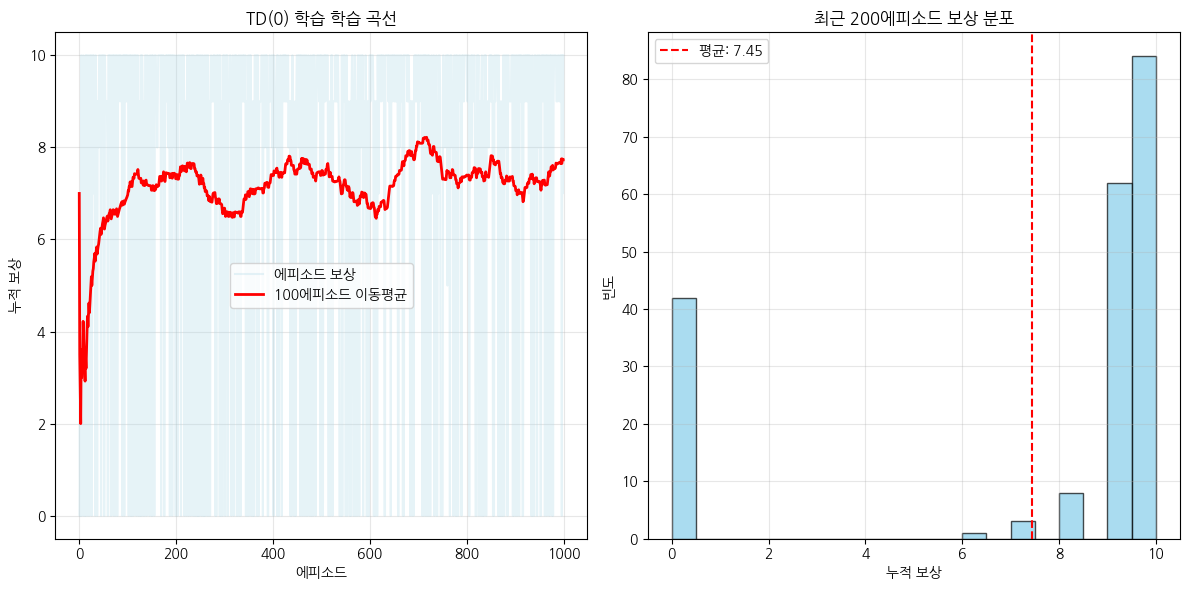

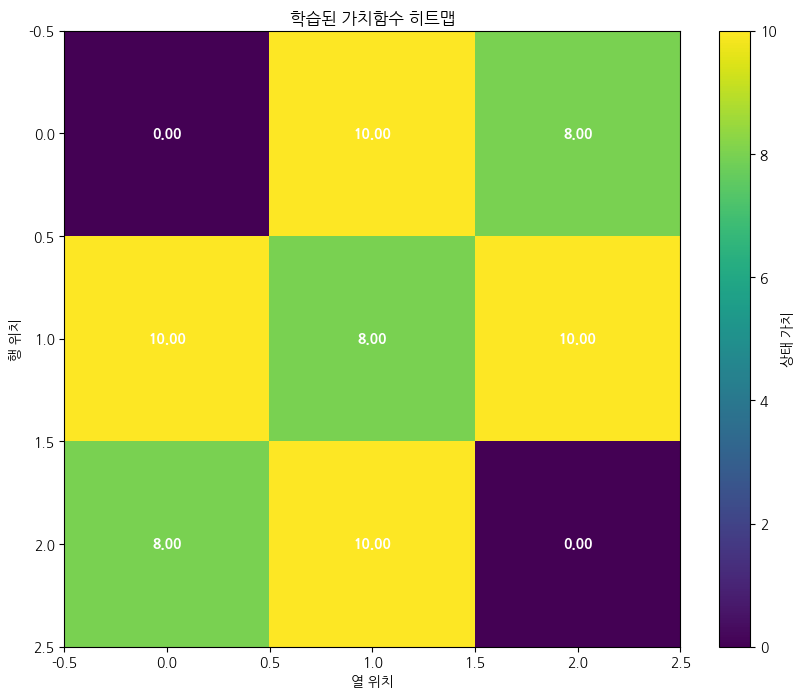

학습 완료!


In [ ]:
# TD(0) 에이전트 생성 및 학습
agent = TD0(
    env=env,
    alpha=0.1,      # 학습률
    gamma=0.9,      # 할인 인수
    epsilon=0.1     # 탐험률
)

# TDBase 클래스의 train 메서드 사용
episodes, rewards, steps = agent.train(episodes=1000)

# 결과 시각화
agent.plot_results(episodes, rewards, steps, "TD(0) 학습")

print("학습 완료!")


---

# TD Lambda


In [ ]:
import random
from collections import defaultdict


# 매 방문(Every-visit) 몬테카를로 방법
# 1. 정책 π를 초기화
# 2. 가치함수 V(s)와 방문 횟수 N(s)를 초기화
# 3. 반복:
#    a. 정책 π에 따라 한 에피소드 실행
#    b. G ← 0 (리턴값 초기화)
#    c. 에피소드의 각 단계 t를 역순으로 반복:
#       i. G ← γG + R_t (감가율 적용하여 리턴값 갱신)
#       ii. N(S_t) ← N(S_t) + 1
#       iii. V(S_t) ← V(S_t) + (G - V(S_t)) / N(S_t)

# 1. 정책 π를 초기화
# epsilon-greedy 정책 사용 (무작위 탐험과 그리디 선택의 조합)
epsilon = 0.1

# 2. 가치함수 V(s)와 방문 횟수 N(s)를 초기화
V = defaultdict(float)  # 상태 가치함수
N = defaultdict(int)    # 상태 방문 횟수
gamma = 0.9             # 할인 인수

# 3. 반복:
for episode in range(1000):
    # a. 정책 π에 따라 한 에피소드 실행
    states = []
    rewards = []

    # GridWorld는 reset 메서드가 없으므로 초기 상태를 직접 설정
    state = (2, 2)  # 시작 상태 설정
    done = False

    while not done:
        # epsilon-greedy 정책으로 행동 선택
        if random.random() < epsilon:
            action = random.choice(env.actions)
        else:
            # 가장 높은 Q값을 가진 행동 선택 (그리디)
            q_values = [V[state] for _ in range(len(env.actions))]
            action = env.actions[q_values.index(max(q_values))]

        states.append(state)

        # GridWorld의 메서드를 사용하여 다음 상태와 보상 계산
        next_state = env.get_next_state(state, action)
        reward = env.get_reward(state, action, next_state)
        done = env.is_terminal(next_state)

        rewards.append(reward)
        state = next_state

    # b. G ← 0 (리턴값 초기화)
    G = 0

    # c. 에피소드의 각 단계 t를 역순으로 반복:
    for t in range(len(states)-1, -1, -1):
        # i. G ← γG + R_t (감가율 적용하여 리턴값 갱신)
        G = gamma * G + rewards[t]

        # ii. N(S_t) ← N(S_t) + 1
        N[states[t]] += 1

        # iii. V(S_t) ← V(S_t) + (G - V(S_t)) / N(S_t)
        V[states[t]] = V[states[t]] + (G - V[states[t]]) / N[states[t]]

print("매 방문 몬테카를로 방법 학습 완료!")
print(f"학습된 상태 수: {len(V)}")


매 방문 몬테카를로 방법 학습 완료!
학습된 상태 수: 8


---

### TD Lambda Class ver

In [ ]:

class TDLambda(TDBase):
    """
    TD(λ) 알고리즘 - 여러 단계를 고려하는 확장 알고리즘
    1. 정책 π, 가치함수 V(s), 적격 흔적(eligibility traces) E(s)를 초기화
    2. 반복:
       a. 현재 상태 s 관찰
       b. 정책 π에 따라 행동 a 선택 및 실행
       c. 보상 r과 다음 상태 s' 관찰
       d. TD 오차 = r + γV(s') - V(s) 계산
       e. E(s) = E(s) + 1  # 현재 상태의 적격 흔적 증가
       f. 모든 상태 s에 대해:
          i. V(s) = V(s) + α[TD 오차]E(s)  # 모든 상태를 적격 흔적에 비례하여 업데이트
          ii. E(s) = γλE(s)  # 적격 흔적 감소
       g. s = s'로 갱신
    """

    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=0.1, lambda_=0.9):
        # 1. 정책 π, 가치함수 V(s), 적격 흔적(eligibility traces) E(s)를 초기화
        super().__init__(env, alpha, gamma, epsilon)
        self.lambda_ = lambda_  # λ 매개변수 (흔적 감쇠율)
        self.eligibility_traces = defaultdict(lambda: defaultdict(float))  # 적격 흔적 E(s,a)

    def reset_episode(self):
        """에피소드 시작 시 적격 흔적 초기화"""
        self.eligibility_traces = defaultdict(lambda: defaultdict(float))

    def update_step(self, state, action, reward, next_state, done):
        """
        TD(λ) 업데이트:
        1. TD 오차 계산: δ = r + γ * max_a'Q(s',a') - Q(s,a)
        2. 현재 상태-행동의 적격 흔적 증가: E(s,a) ← E(s,a) + 1
        3. 모든 상태-행동에 대해 업데이트:
           - Q(s,a) ← Q(s,a) + α * δ * E(s,a)
           - E(s,a) ← γ * λ * E(s,a)
        """
        # a. 현재 상태 s 관찰 (이미 완료)
        # b. 정책 π에 따라 행동 a 선택 및 실행 (이미 완료)
        # c. 보상 r과 다음 상태 s' 관찰 (이미 완료)

        # 현재 Q값
        current_q = self.Q[state][action]

        # d. TD 오차 = r + γV(s') - V(s) 계산
        if done:
            target_q = reward
        else:
            next_q_values = [self.Q[next_state][a] for a in self.env.actions]
            target_q = reward + self.gamma * max(next_q_values)

        # TD 오차 계산
        td_error = target_q - current_q

        # e. E(s) = E(s) + 1  # 현재 상태의 적격 흔적 증가
        self.eligibility_traces[state][action] += 1.0

        # f. 모든 상태 s에 대해:
        states_to_remove = []
        for s in list(self.eligibility_traces.keys()):
            actions_to_remove = []
            for a in list(self.eligibility_traces[s].keys()):
                if self.eligibility_traces[s][a] > 0:
                    # i. V(s) = V(s) + α[TD 오차]E(s)  # 모든 상태를 적격 흔적에 비례하여 업데이트
                    self.Q[s][a] += self.alpha * td_error * self.eligibility_traces[s][a]

                    # ii. E(s) = γλE(s)  # 적격 흔적 감소
                    self.eligibility_traces[s][a] *= self.gamma * self.lambda_

                    # 매우 작은 흔적 제거 (메모리 효율성)
                    if self.eligibility_traces[s][a] < 1e-6:
                        actions_to_remove.append(a)

            # 작은 흔적들 제거
            for a in actions_to_remove:
                del self.eligibility_traces[s][a]

            # 빈 상태 제거
            if not self.eligibility_traces[s]:
                states_to_remove.append(s)

        # 빈 상태들 제거
        # 더 이상 쓸모없는 상태들을 지워주는 과정
        # 적격 흔적이 모두 없어진 상태들은 메모리에서 완전히 삭제해야 함
        # 이렇게 하지 않으면 컴퓨터 메모리가 계속 쌓여서 느려질 수 있음
        # 빈 딕셔너리만 남아있는 상태들을 하나씩 찾아서 지워줌
        for s in states_to_remove:
            del self.eligibility_traces[s]

        # g. s = s'로 갱신 (train 메서드에서 처리)


에피소드 0: 평균 보상 = 7.00
에피소드 100: 평균 보상 = 6.66
에피소드 200: 평균 보상 = 6.36
에피소드 300: 평균 보상 = 6.72
에피소드 400: 평균 보상 = 7.15
에피소드 500: 평균 보상 = 7.27
에피소드 600: 평균 보상 = 6.94
에피소드 700: 평균 보상 = 6.64
에피소드 800: 평균 보상 = 6.78
에피소드 900: 평균 보상 = 6.84


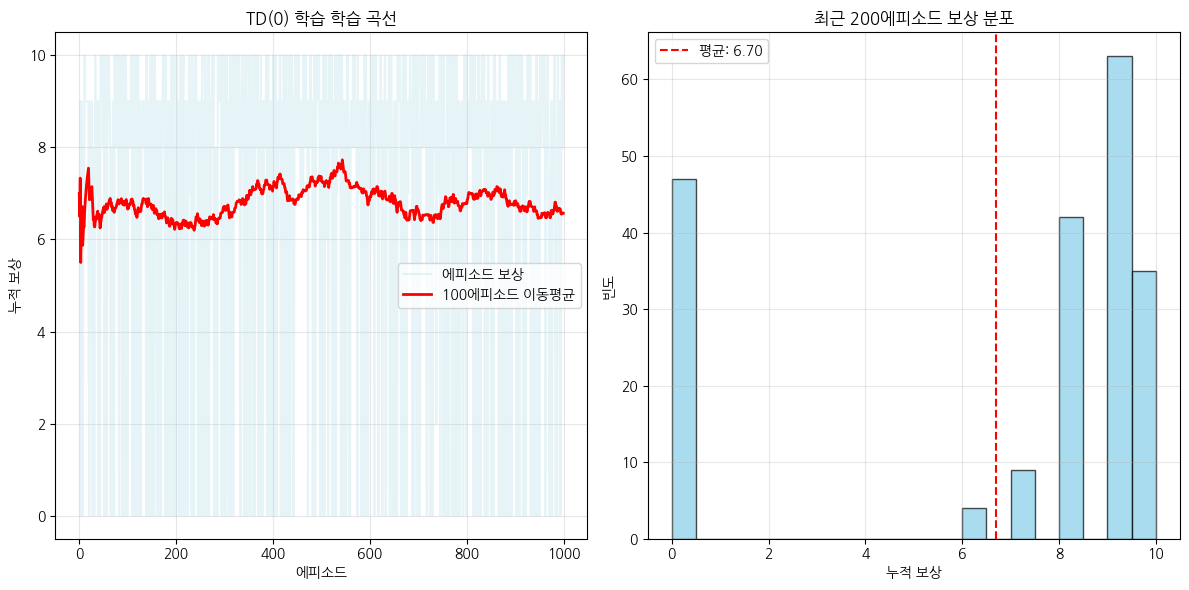

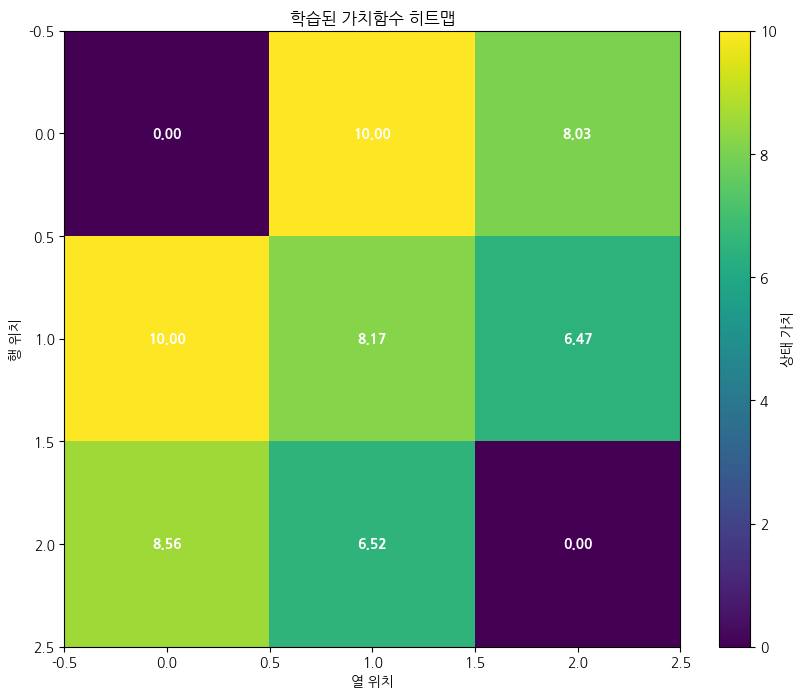

학습 완료!


In [ ]:
# TD(0) 에이전트 생성 및 학습
agent = TDLambda(
    env=env,
    alpha=0.1,      # 학습률
    gamma=0.9,      # 할인 인수
    epsilon=0.1     # 탐험률
)

# TDBase 클래스의 train 메서드 사용
episodes, rewards, steps = agent.train(episodes=1000)

# 결과 시각화
agent.plot_results(episodes, rewards, steps, "TD(0) 학습")

print("학습 완료!")
